In [2]:
import generate
import symae
import os
import numpy as np
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print(tf.__version__)

Num GPUs Available:  2
2.9.1


In [4]:
# Ok, What's in symae?
# Downsampler, DownsamplerDense, NuisanceEncoder, NuisanceEncoder1D, NuisanceEncoderDense1D, 
# SymmetricEncoder,SymmetricEncoder1D,SymmetricEncoderDense1D,DistributeZsym,LatentCat,DroppedLatentCat, 
# Mixer, Mixer1D, MixerDense1D, Upsampler, UpsamplerDense
# They are all Neural Nets. But where is the SymAE?
#####
# SymmetricEncoder: n, ntau, nr, nt, nc = input_tensor.get_shape()
# Consider a batch of 32 video samples, 
# where each sample is a 128x128 RGB image with channels_last data format, across 10 timesteps. 
# The batch input shape is (32, 10, 128, 128, 3).
#####
# NuisanceEncoder: n, ntau, nr, nt, nc = input_tensor.get_shape()
#####
# Let's Clarifying Notations Now!!!!!

In [5]:
# Parameters related to data itself
N=1000 # N is the Cardinality of the data set X, say n_X in the paper
nt=20 # nt is the number of instances in each X_i, say n_tau in the paper (Xi[1]...Xi[nt])
d=100 # d is the dimensions of each "fundamental" data, say d=dim Xi[j] (e.g. d=28*28 for mnist)

# Parameters related to SymAE
p=8 # symmetric encoder latent dimensions, p=dim Ci (Coherent Code)
q=22 # nuisance encoder latent dimensions, q=dim Ni[j] (Dissimilar Code)

# Parameters related to NeuralNets
kernel_size=5 # How to convolute, the size of the kernel
filters=64 # How many filters in each convolution layer

# Parameters related to my specific algorithm of generating MRA data
ne=10 # Only use g0,g1...g9
sigma=0.1 # The intensity of the noise

In [6]:
# Build symmetric encoder
sym_enc_input=tfk.Input(shape=(nt,d,1), dtype='float32', name='sym_enc_input')
sym_enc_output=symae.SymmetricEncoder1D(kernel_size,filters,[2,2,2,2],[2,2,2,2],p)(sym_enc_input)
sym_encoder=tfk.Model(sym_enc_input, sym_enc_output, name='sym_encoder')
sym_encoder.summary()

2022-06-02 14:15:10.349715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 14:15:11.576388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-06-02 14:15:11.577199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14254 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:1b:00.0, compute capability: 8.6


Model: "sym_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sym_enc_input (InputLayer)  [(None, 20, 100, 1)]      0         
                                                                 
  (SymmetricEncoder1D)       (None, 8)                 53512     
                                                                 
Total params: 53,512
Trainable params: 53,448
Non-trainable params: 64
_________________________________________________________________


In [7]:
# Build nuisance encoder
nui_enc_input=tfk.Input(shape=(nt,d,1), dtype='float32', name='sym_enc_input')
nui_enc_output=symae.NuisanceEncoder1D(kernel_size,filters,[2,2,2],[2,2,2,2],q)(nui_enc_input)
nui_enc_flatten=tfkl.Flatten()(nui_enc_output)
nui_encoder=tfk.Model(nui_enc_input, nui_enc_flatten, name='nui_encoder')
nui_encoder.summary()

Model: "nui_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sym_enc_input (InputLayer)  [(None, 20, 100, 1)]      0         
                                                                 
  (NuisanceEncoder1D)        (None, 20, 22)            61334     
                                                                 
 flatten_2 (Flatten)         (None, 440)               0         
                                                                 
Total params: 61,334
Trainable params: 61,270
Non-trainable params: 64
_________________________________________________________________


In [8]:
# Build distribute in decoder
distribute_input = tfk.Input(shape=(p+q*nt), name='latentcode')
distribute_output=symae.DistributeZsym(nt, p, q)(distribute_input)
distzsym = tfk.Model(distribute_input, distribute_output, name='distzsym')
distzsym.summary()

Model: "distzsym"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latentcode (InputLayer)     [(None, 448)]             0         
                                                                 
  (DistributeZsym)           (None, 20, 30)            0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [9]:
#Build mixer in decoder
mixer_input = tfk.Input(shape=(nt,p+q), name='mixer_input')
mixer_output=symae.Mixer1D(kernel_size,filters,10,d)(mixer_input)
mixer = tfk.Model(mixer_input, mixer_output, name='mixer') 
mixer.summary()

Model: "mixer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mixer_input (InputLayer)    [(None, 20, 30)]          0         
                                                                 
  (Mixer1D)                  (None, 20, 100, 1)        83447     
                                                                 
Total params: 83,447
Trainable params: 83,319
Non-trainable params: 128
_________________________________________________________________


In [10]:
# Build encoder
encoder_input=tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
znuisance=nui_encoder(encoder_input)
zsym=sym_encoder(encoder_input)
latentcat=symae.LatentCat(0.65) #0.4 droupout
encoder_output=latentcat(zsym,znuisance)
encoder=tfk.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 20, 100, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sym_encoder (Functional)       (None, 8)            53512       ['encoder_input[0][0]']          
                                                                                                  
 nui_encoder (Functional)       (None, 440)          61334       ['encoder_input[0][0]']          
                                                                                                  
  (LatentCat)                   (None, 448)          0           ['sym_encoder[0][0]',      

In [11]:
# Build decoder
decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
decoder_output=mixer(distzsym(decoder_input))
decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latentcode (InputLayer)     [(None, 448)]             0         
                                                                 
 distzsym (Functional)       (None, 20, 30)            0         
                                                                 
 mixer (Functional)          (None, 20, 100, 1)        83447     
                                                                 
Total params: 83,447
Trainable params: 83,319
Non-trainable params: 128
_________________________________________________________________


In [12]:
#Build SymAE
model=tf.keras.Model(encoder_input, decoder(encoder_output) , name='autoencoder_clone')
model.summary()

Model: "autoencoder_clone"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 20, 100, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sym_encoder (Functional)       (None, 8)            53512       ['encoder_input[0][0]']          
                                                                                                  
 nui_encoder (Functional)       (None, 440)          61334       ['encoder_input[0][0]']          
                                                                                                  
  (LatentCat)                   (None, 448)          0           ['sym_encoder[0][

In [13]:
model.compile(optimizer='adam', loss='mse')

In [14]:
X=generate.generate_smooth(d,nt,N,ne,sigma)

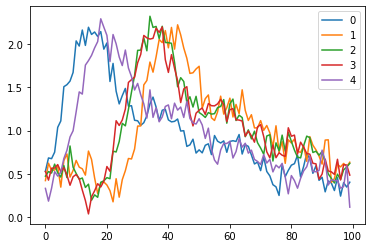

In [15]:
import matplotlib.pyplot as plt
for j in range(5):
    plt.plot(range(100),X[0,j,:],label='%d'%j)
plt.legend()
plt.show()

In [16]:
history=model.fit(X,X,epochs=50)

Epoch 1/50


2022-06-02 14:15:22.916764: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-06-02 14:15:24.377157: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-02 14:15:24.381070: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-06-02 14:15:24.381083: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-06-02 14:15:24.381137: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

32/32 [==============================] - 7s 48ms/step - loss: 0.3371
Epoch 2/50
32/32 [==============================] - 1s 29ms/step - loss: 0.1079
Epoch 3/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0773
Epoch 4/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0658
Epoch 5/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0633
Epoch 6/50
32/32 [==============================] - 1s 29ms/step - loss: 0.0601
Epoch 7/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0569
Epoch 8/50
32/32 [==============================] - 1s 28ms/step - loss: 0.0559
Epoch 9/50
32/32 [==============================] - 1s 29ms/step - loss: 0.0533
Epoch 10/50
32/32 [==============================] - 1s 29ms/step - loss: 0.0519
Epoch 11/50
32/32 [==============================] - 1s 28ms/step - loss: 0.0495
Epoch 12/50
32/32 [==============================] - 1s 29ms/step - loss: 0.0492
Epoch 13/50
32/32 [=============================

In [19]:
model.evaluate(X,  X)

32/32 [==============================] - 0s 13ms/step - loss: 0.0286


0.02860780991613865

In [22]:
Y=model.predict(X)
Y.shape

32/32 [==============================] - 0s 9ms/step


(1000, 20, 100, 1)

In [89]:
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

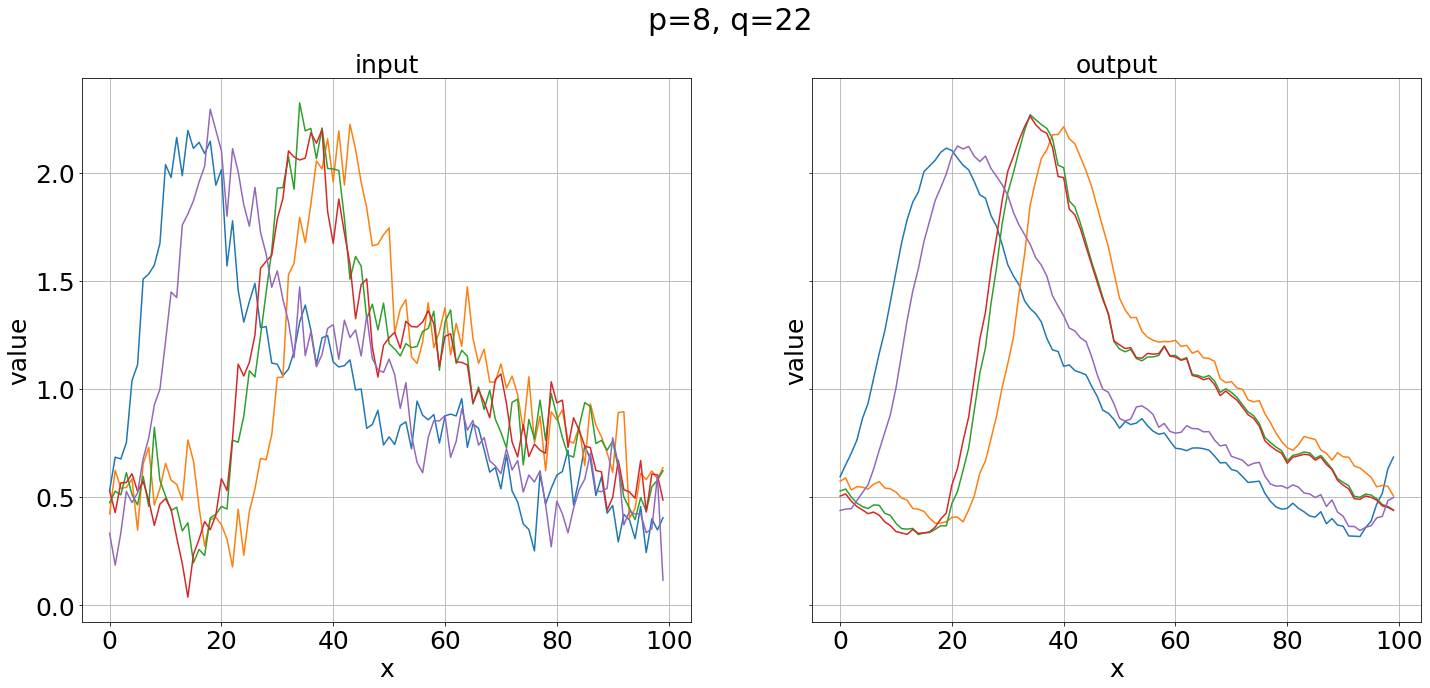

In [90]:
I=0 # Check X[I,:,:]
J=5 # Check X[I,1:J,:]
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(24,10))
fig.suptitle('p=%d, q=%d'%(p,q))
axs[0].set_title('input')
axs[1].set_title('output')
for j in range(J):
    axs[0].plot(range(100),X[I,j,:],label='%d'%j)
for j in range(J):
    axs[1].plot(range(100),Y[I,j,:],label='%d'%j)
for ax in axs.flat:
    ax.grid(True)
    ax.set(xlabel='x',ylabel='value')